# **Predicting the Alpha Signal using Microblogging Data**
1. **`Problem Statement`**:
   - A hedge fund uses 6 financial factors to predict the alpha signal in a stock. This alpha signal
     is used to make purchase decisions about the stock. The hedge fund now collected and
     tagged **Microblogging** data for sentiment from the Social Media platform called **StockTwits**.
   - StockTwits is used by people who regularly trade stocks. People on this platform tweet
     about stocks using the special character 'dollar' to indicate the name of the stock. These
     microblogs similar to tweets might contain important information about the alpha signal in
     a stock.
   - Your goal is to build a sentiment analysis model using the tagged data. This sentiment
     analysis model should then be used to generate a new stock factor which together with the
     other stock factors should be used to predict the Alpha Signal.
   - The hedge fund has anonymyzed the data, which contains 7 stock factors and an alpha signal.
     This alpha signal is generated using a near perfect algorithmic trading strategy. Unfortunately,
     the number of stock factors, collected to run that strategy, are extremely high and have to be
     collected from a large number of data vendors at a high price.
   - Replicating the alpha signal generated from that strategy using just the 7 Stock Factors and
     the factor generated from sentiment analysis of the stocktwits would make the company
     incur significantly less costs to perform their trades.


2. **`Data Description`**:
   - Two json files: ‘sentiment_train.json’ and ‘sentiment_test.json’ are provided to you which
     contain **stocktwit data**, the **timestamp** of collecting the tweet and the **ticker** (stock
     identifier). The ‘sentiment_train.json’ also contains the tagged **sentiment** score ranging
     from 0 - 3.
   - There are two csv files provided to you: ‘train_factors.csv’ and ‘test_factors.csv’.
     The ‘train_factors.csv’ file contains the following fields:
        1. **Id**: Index or unique identifier for a record, in the individual data file.
        2. **date**: The date at which the factors are generated
        3. **ticker**: The identifier through which the company is listed in the stock
           exchange
        4. **SF1** - **SF7**: 7 anonymized Stock Factors that can be used to predict.
        5. **alpha**: The alpha signal generated by using a high performing algorithmic
           trading strategy. (range: 1 - 4)
   - You must first build models using the 7 anonymized stock factors (SF1 - SF7) to predict
     alpha. Then add the sentiment scores and build more models to predict alpha. Detail the
     improvement observed using the sentiment factor compared to just using the other stock
     factors.   


3. **`Evaluation Metric`**:
   - Macro F1 Score.

## Importing libraries

In [1]:
# to deal with dataframes
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)  
pd.set_option('display.expand_frame_repr',False)
pd.set_option('display.max_colwidth',-1)

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

# for text preprocessing
import re
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
from textblob import TextBlob
import emoji

# for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import StackingClassifier

<ipython-input-1-b1041aa147bd>:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


## Reading dataset

In [2]:
# factors dataset
train_1=pd.read_csv('train_factors.csv') 
test_1=pd.read_csv('test_factors.csv')

- Converting and saving `.json` file into `.csv` file.

In [3]:
# train set
#json_train=pd.read_json("train_data.json")
#a=[]
#b=[]
#c=[]
#d=[]
#for i in json_train.records:
#    d.append(i['sentiment_score'])
#    c.append(i['stocktwit_tweet'])
#    b.append(pd.to_datetime(i['timestamp']))
#    a.append(i['ticker'])
    
#train_2=pd.DataFrame({'ticker':a,'timestamp':b,'tweet':c,'sentiment':d}) 
#train_2.to_csv('train_2.csv')

# test set
#json_test=pd.read_json("test_data.json")
#a=[]
#b=[]
#c=[]
#for i in json_test.records:
#    c.append(i['stocktwit_tweet'])
#    b.append(pd.to_datetime(i['timestamp']))
#    a.append(i['ticker'])

#test_2=pd.DataFrame({'ticker':a,'timestamp':b,'tweet':c})
#test_2.to_csv('test_2.csv')

In [4]:
# tweet dataset
train_2=pd.read_csv('train_2.csv')
test_2=pd.read_csv('test_2.csv')

## Taking a look through 

**train** set

In [5]:
train_1.head()

Id      date ticker       SF1       SF2       SF3       SF4       SF5       SF6       SF7  alpha
0  1   21/08/18  $NTAP -0.628652  0.988891 -0.055714  0.774379  0.551089 -1.329229 -0.995539  2    
1  2   11/10/18  $WYNN  1.315786  1.438754  0.187327  0.608933 -1.153030  1.859441  0.730995  3    
2  3   21/08/18  $DRI  -1.141388 -1.455016  0.332755  0.674502  0.111326 -0.478597 -1.488157  1    
3  4   10/07/18  $ge   -0.054839 -1.454149 -0.162267 -0.681870  0.307869 -0.529987  0.404172  2    
4  5   12/09/18  $FE   -0.686366  0.838865  0.073830  0.679024  0.329463  1.262782 -1.024042  2

In [6]:
train_2.head()

Unnamed: 0 ticker                  timestamp                                                                                                                tweet  sentiment
0  0           $AMD   2018-09-19 18:38:28+00:00  $AMD going up but hesitating however chart is very stable and going upward                                           3        
1  1           $CAT   2018-10-09 03:51:06+00:00  @inforlong @MariaGascon Despite\nChina trade war $CAT held very well 👍                                               3        
2  2           $AVGO  2018-07-12 13:35:32+00:00  $AVGO WTF?                                                                                                           2        
3  3           $PH    2018-07-19 03:32:50+00:00  $PH\n New Insider Filing On: \n MULLER KLAUS PETER\nTransaction Code: \n http://www.filingscanner.com/Alerts/PH.php  2        
4  4           $FB    2018-08-23 19:07:54+00:00  $FB if it bounces tommorrow do the right thing and GTFO                                                              3

In [7]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27006 entries, 0 to 27005
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      27006 non-null  int64  
 1   date    27006 non-null  object 
 2   ticker  27006 non-null  object 
 3   SF1     27006 non-null  float64
 4   SF2     27006 non-null  float64
 5   SF3     27006 non-null  float64
 6   SF4     27006 non-null  float64
 7   SF5     27006 non-null  float64
 8   SF6     27006 non-null  float64
 9   SF7     27006 non-null  float64
 10  alpha   27006 non-null  int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 2.3+ MB


In [8]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039131 entries, 0 to 1039130
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1039131 non-null  int64 
 1   ticker      1039131 non-null  object
 2   timestamp   1039131 non-null  object
 3   tweet       1039131 non-null  object
 4   sentiment   1039131 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 39.6+ MB


There are **no missing values** both train sets.

In [9]:
train_1.describe(include='all')

Id      date ticker           SF1           SF2           SF3           SF4           SF5           SF6           SF7         alpha
count   27006.000000  27006     27006  27006.000000  27006.000000  27006.000000  27006.000000  27006.000000  27006.000000  27006.000000  27006.000000
unique NaN            123       1304  NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN          
top    NaN            26/07/18  $BAC  NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN          
freq   NaN            344       90    NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN          
mean    13503.500000  NaN       NaN    0.005429     -0.001005     -0.024421     -0.042420      0.041465      0.002597      0.036744      2.379582    
std     7796.105021   NaN       NaN    0.941853      0.996130      0.539555      1.111309      0.976028      0.998839      1.204473      1.008681    
min     1.000000      NaN       NaN   -4.114670     -4.578587     -2.609150     -6.329798     -5.480268     -4.338751     -5.347869      1.000000    
25%     6752.250000   NaN       NaN   -0.596792     -0.666310     -0.300187     -0.767247     -0.518641     -0.668027     -0.688198      2.000000    
50%     13503.500000  NaN       NaN    0.012104     -0.013257     -0.040786     -0.058629      0.072127      0.007417      0.081374      2.000000    
75%     20254.750000  NaN       NaN    0.611574      0.669094      0.241424      0.677433      0.616538      0.674592      0.807556      3.000000    
max     27006.000000  NaN       NaN    4.415048      3.822270      3.452486      4.907407      4.779911      4.075428      5.182912      4.000000

In [10]:
train_2.describe(include='all')

Unnamed: 0   ticker                  timestamp    tweet     sentiment
count   1.039131e+06  1039131  1039131                    1039131  1.039131e+06
unique NaN            2181     905458                     959608  NaN          
top    NaN            $AMD     2018-08-13 14:00:03+00:00  $AMD    NaN          
freq   NaN            163675   65                         2474    NaN          
mean    5.195650e+05  NaN      NaN                        NaN      2.203079e+00
std     2.999714e+05  NaN      NaN                        NaN      1.105371e+00
min     0.000000e+00  NaN      NaN                        NaN      0.000000e+00
25%     2.597825e+05  NaN      NaN                        NaN      2.000000e+00
50%     5.195650e+05  NaN      NaN                        NaN      2.000000e+00
75%     7.793475e+05  NaN      NaN                        NaN      3.000000e+00
max     1.039130e+06  NaN      NaN                        NaN      4.000000e+00

**test** set

In [11]:
test_1.head()

Id      date ticker       SF1       SF2       SF3       SF4       SF5       SF6       SF7
0  270007  21/07/18  $INTC -3.062194  1.223466  1.741714  2.279266 -1.323573 -0.274912 -4.504449
1  270008  05/10/18  $CTSH  0.816263 -2.184408  0.157975 -0.264743 -0.836282  0.046276  0.826353
2  270009  01/10/18  $CB    0.401281  0.091604  0.083411 -1.147041 -0.485223 -0.601060  1.012811
3  270010  24/10/18  $CTAS -0.783521  1.192929  0.813831 -0.368166 -1.113656 -0.553581 -0.683803
4  270011  27/07/18  $intc  0.796507  0.455341  0.679032  0.354336 -1.799055  0.126153  0.297111

In [12]:
test_2.head()

Unnamed: 0 ticker                  timestamp                                                                                                         tweet
0  0           $CELG  2018-10-25 14:26:16+00:00  $CELG nothing to be exited about                                                                            
1  1           $AMD   2018-07-13 13:50:39+00:00  $AMD yall exhaust your buyer on first green candle,,,, byeeeeee                                             
2  2           $AMD   2018-09-25 19:10:54+00:00  $AMD day traders day.                                                                                       
3  3           $CBS   2018-07-27 22:45:48+00:00  $CBS https://tenor.com/wLB8.gif                                                                             
4  4           $MU    2018-07-31 14:59:06+00:00  $MU weak price action so far today. Don’t be afraid to go short, it’s gonna break support and free fall soon

In [13]:
test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11575 entries, 0 to 11574
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      11575 non-null  int64  
 1   date    11575 non-null  object 
 2   ticker  11575 non-null  object 
 3   SF1     11575 non-null  float64
 4   SF2     11575 non-null  float64
 5   SF3     11575 non-null  float64
 6   SF4     11575 non-null  float64
 7   SF5     11575 non-null  float64
 8   SF6     11575 non-null  float64
 9   SF7     11575 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 904.4+ KB


In [14]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265022 entries, 0 to 265021
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  265022 non-null  int64 
 1   ticker      265022 non-null  object
 2   timestamp   265022 non-null  object
 3   tweet       265022 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.1+ MB


There are **no missing values** both test sets.

In [15]:
test_1.describe(include='all')

Id      date ticker           SF1           SF2           SF3           SF4           SF5           SF6           SF7
count   11575.000000   11575     11575  11575.000000  11575.000000  11575.000000  11575.000000  11575.000000  11575.000000  11575.000000
unique NaN             123       1012  NaN           NaN           NaN           NaN           NaN           NaN           NaN          
top    NaN             25/07/18  $AMZN NaN           NaN           NaN           NaN           NaN           NaN           NaN          
freq   NaN             152       46    NaN           NaN           NaN           NaN           NaN           NaN           NaN          
mean    275794.000000  NaN       NaN    0.001546      0.003995     -0.029754     -0.047606      0.053956     -0.000428      0.037914    
std     3341.559017    NaN       NaN    0.924519      0.997903      0.537651      1.097842      0.965109      1.003503      1.192223    
min     270007.000000  NaN       NaN   -4.130410     -4.034445     -4.259227     -4.704038     -4.545787     -4.317883     -5.031257    
25%     272900.500000  NaN       NaN   -0.580470     -0.673206     -0.308838     -0.754051     -0.502280     -0.682896     -0.684029    
50%     275794.000000  NaN       NaN    0.011865     -0.001464     -0.044590     -0.055108      0.084598      0.008303      0.081955    
75%     278687.500000  NaN       NaN    0.600965      0.685805      0.228484      0.649046      0.620426      0.680800      0.807105    
max     281581.000000  NaN       NaN    4.519223      4.108285      2.763214      4.794511      5.646556      3.900014      6.005315

In [16]:
test_2.describe(include='all')

Unnamed: 0  ticker                  timestamp   tweet
count   265022.000000  265022  265022                     265022
unique NaN             1444    254753                     252890
top    NaN             $AMD    2018-10-29 14:00:03+00:00  $AMD  
freq   NaN             42140   18                         622   
mean    132510.500000  NaN     NaN                        NaN   
std     76505.405858   NaN     NaN                        NaN   
min     0.000000       NaN     NaN                        NaN   
25%     66255.250000   NaN     NaN                        NaN   
50%     132510.500000  NaN     NaN                        NaN   
75%     198765.750000  NaN     NaN                        NaN   
max     265021.000000  NaN     NaN                        NaN

## Preprocessing 1

### **Factors dataset**
- We will change the **date** format and convert it into datetime datatype.

In [17]:
# replacing / with -
train_1['date']=train_1['date'].str.replace("/","-")
test_1['date']=test_1['date'].str.replace("/","-")

# changing the datatype
train_1['date']=pd.to_datetime(train_1['date'])
test_1['date']=pd.to_datetime(test_1['date'])

### **Tweet dataset**

- Changing the name of **Unnamed: 0** column to **Id**

In [18]:
train_2=train_2.rename(columns={"Unnamed: 0":"Id"})

test_2=test_2.rename(columns={"Unnamed: 0":"Id"})

- Now we will extract the **date** from **timestamp** and change the column name.
- Later we will change the **date** format.

In [19]:
# changing the datatype
train_2['timestamp']=pd.to_datetime(train_2['timestamp'])
test_2['timestamp']=pd.to_datetime(test_2['timestamp'])

# extracting date and saving in new column
train_2['date']=train_2['timestamp'].dt.strftime('%d/%m/%y')
test_2['date']=test_2['timestamp'].dt.strftime('%d/%m/%y')

# changing the datatype
train_2['date']=pd.to_datetime(train_2['date'])
test_2['date']=pd.to_datetime(test_2['date'])

# removing timestamp column
train_2=train_2.drop(columns=['timestamp'])
test_2=test_2.drop(columns=['timestamp'])

#### Removing **links** from tweet

In [20]:
train_2['tweet']=train_2['tweet'].str.replace('http\S*|www\S*',"",case=False)
test_2['tweet']=test_2['tweet'].str.replace('http\S*|www\S*',"",case=False)

#### Removing **emojis** from tweet

In [21]:
def remove_emoji(tweet):
    emoji_pattern=re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",flags=re.UNICODE)
    return emoji_pattern.sub(r'',tweet)

train_2['tweet']=train_2['tweet'].apply(remove_emoji)
test_2['tweet']=test_2['tweet'].apply(remove_emoji)

#### Removing **numbers** from tweet

In [22]:
def remove_numbers(tweet):
    tweet=''.join([i for i in tweet if not i.isdigit()])         
    return tweet

train_2['tweet']=train_2['tweet'].apply(remove_numbers)
test_2['tweet']=test_2['tweet'].apply(remove_numbers)

#### Removing **tickers** from tweets

In [23]:
y_train=[]
[y_train.append(" ".join(filter(lambda y_train:y_train[0]!='$',train_2['tweet'][i].split()))) for i in range(0,train_2.shape[0])]
train_2['tweet']=y_train

y_test=[]
[y_test.append(" ".join(filter(lambda y_test:y_test[0]!='$',test_2['tweet'][i].split()))) for i in range(0,test_2.shape[0])]
test_2['tweet']=y_test

#### Removing **twitter handles** from tweets (if any)

In [24]:
train_2['tweet']=train_2['tweet'].str.replace("@[\w]*","")
test_2['tweet']=test_2['tweet'].str.replace("@[\w]*","")

#### Removing **special characters** from tweet

In [25]:
train_2['tweet']=train_2['tweet'].str.replace("[^a-zA-Z]"," ")
test_2['tweet']=test_2['tweet'].str.replace("[^a-zA-Z]"," ")

#### Removing **repeating words** from tweet

In [26]:
train_2['tweet']=train_2['tweet'].apply(lambda x : re.sub(r'(.)\1{1,}', r'\1\1',x))
test_2['tweet']=test_2['tweet'].apply(lambda x : re.sub(r'(.)\1{1,}', r'\1\1',x))

#### Removing **accented characters** from tweet

In [27]:
def remove_accented_chars(tweet):
    tweet=unicodedata.normalize('NFKD',tweet).encode('ascii','ignore').decode('utf-8','ignore')
    return tweet

train_2['tweet']=train_2['tweet'].apply(remove_accented_chars)
test_2['tweet']=test_2['tweet'].apply(remove_accented_chars)

#### **Lower casing** tweet

In [28]:
train_2['tweet']=train_2['tweet'].str.lower()
test_2['tweet']=test_2['tweet'].str.lower()

#### **Contractions**

In [29]:
CONTRACTION_MAP={
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [30]:
def expand_contractions(tweet,contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern=re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match=contraction.group(0)
        first_char=match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_tweet=contractions_pattern.sub(expand_match,tweet)
    expanded_tweet=re.sub("'","",expanded_tweet)
    return expanded_tweet

train_2['tweet']=train_2['tweet'].apply(expand_contractions)
test_2['tweet']=test_2['tweet'].apply(expand_contractions)

#### Removing **stopwords** from tweet

In [31]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

def remove_stopwords(tweet,is_lower_case=False):
    tokens=tokenizer.tokenize(tweet)
    tokens=[token.strip() for token in tokens]
    filtered_tokens=[token for token in tokens if token not in stopword_list]
    filtered_tweet= ' '.join(filtered_tokens)    
    return filtered_tweet

train_2['tweet']=train_2['tweet'].apply(remove_stopwords)
test_2['tweet']=test_2['tweet'].apply(remove_stopwords)

#### **Lemmatization**
- **Lemmatization** is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to Stemming but it brings **context to the words**. So it links words with similar meaning to one word.

- Text preprocessing includes both Stemming as well as Lemmatization. Actually, Lemmatization is preferred over Stemming because Lemmatization does **morphological analysis of the words**.

In [32]:
# splitting the text (tokenizing)
tokenized_data_train=train_2['tweet'].apply(lambda x: x.split()) 
tokenized_data_test=test_2['tweet'].apply(lambda x: x.split()) 

lemmatizer=WordNetLemmatizer()

# lemmatizing the tokenized text
tokenized_data_train=tokenized_data_train.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
tokenized_data_test=tokenized_data_test.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

# again joining the tokenized text
for i in range(len(tokenized_data_train)):
    tokenized_data_train[i]=' '.join(tokenized_data_train[i])

for i in range(len(tokenized_data_test)):
    tokenized_data_test[i]=' '.join(tokenized_data_test[i])    

# saving the clean text    
train_2['tweet']=tokenized_data_train
test_2['tweet']=tokenized_data_test

In [33]:
train_2.head()

Id ticker                                                   tweet  sentiment       date
0  0   $AMD   going hesitating however chart stable going upward      3         2018-09-19
1  1   $CAT   despite china trade war held well                       3         2018-09-10
2  2   $AVGO  wtf                                                     2         2018-12-07
3  3   $PH    new insider filing muller klaus peter transaction code  2         2018-07-19
4  4   $FB    bounce tommorrow right thing gtfo                       3         2018-08-23

In [34]:
test_2.head()

Id ticker                                                                           tweet       date
0  0   $CELG  nothing exited                                                                 2018-10-25
1  1   $AMD   yall exhaust buyer first green candle byee                                     2018-07-13
2  2   $AMD   day trader day                                                                 2018-09-25
3  3   $CBS                                                                                  2018-07-27
4  4   $MU    weak price action far today afraid go short gonna break support free fall soon 2018-07-31

## EDA 1

### **Factors dataset**

#### Univariate Analysis

**`SF1`**

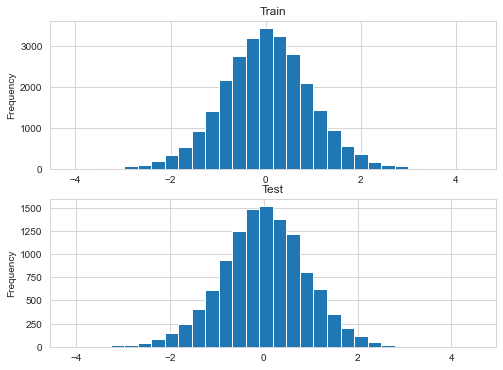

In [35]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(8,6))

train_1['SF1'].plot(kind='hist',bins=30,ax=axis1);
axis1.set_title("Train",size=12);

test_1['SF1'].plot(kind='hist',bins=30,ax=axis2);
axis2.set_title("Test",size=12);

**`SF2`**

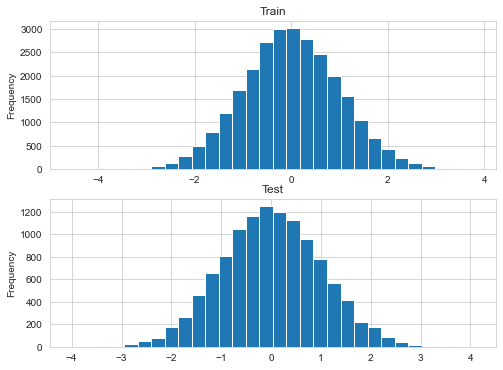

In [36]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(8,6))

train_1['SF2'].plot(kind='hist',bins=30,ax=axis1);
axis1.set_title("Train",size=12);

test_1['SF2'].plot(kind='hist',bins=30,ax=axis2);
axis2.set_title("Test",size=12);

**`SF3`**

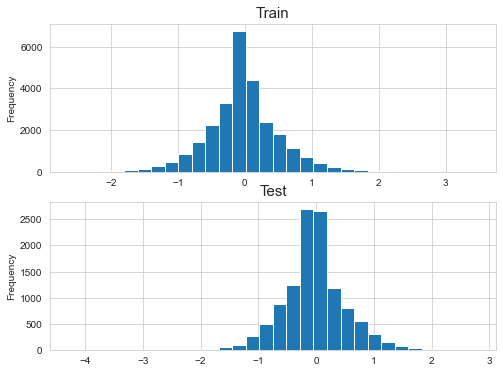

In [37]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(8,6))

train_1['SF3'].plot(kind='hist',bins=30,ax=axis1);
axis1.set_title("Train",size=15);

test_1['SF3'].plot(kind='hist',bins=30,ax=axis2);
axis2.set_title("Test",size=15);

**`SF4`**

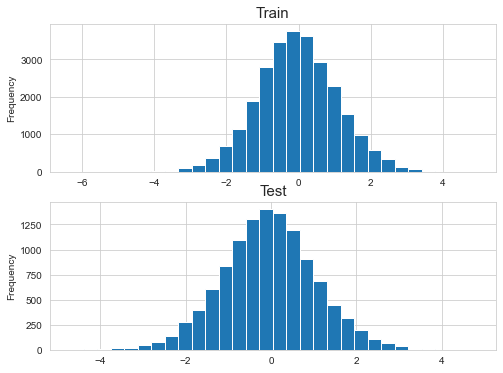

In [38]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(8,6))

train_1['SF4'].plot(kind='hist',bins=30,ax=axis1);
axis1.set_title("Train",size=15);

test_1['SF4'].plot(kind='hist',bins=30,ax=axis2);
axis2.set_title("Test",size=15);

**`SF5`**

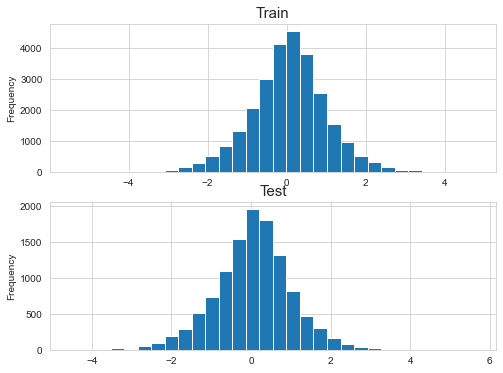

In [39]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(8,6))

train_1['SF5'].plot(kind='hist',bins=30,ax=axis1);
axis1.set_title("Train",size=15);

test_1['SF5'].plot(kind='hist',bins=30,ax=axis2);
axis2.set_title("Test",size=15);

**`SF6`**

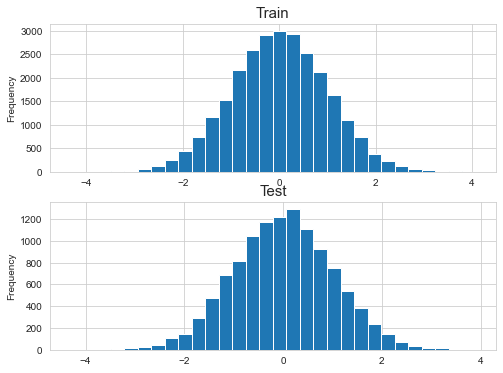

In [40]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(8,6))

train_1['SF6'].plot(kind='hist',bins=30,ax=axis1);
axis1.set_title("Train",size=15);

test_1['SF6'].plot(kind='hist',bins=30,ax=axis2);
axis2.set_title("Test",size=15);

**`SF7`**

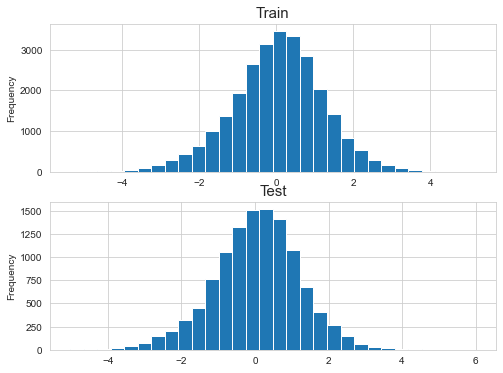

In [41]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(8,6))

train_1['SF7'].plot(kind='hist',bins=30,ax=axis1);
axis1.set_title("Train",size=15);

test_1['SF7'].plot(kind='hist',bins=30,ax=axis2);
axis2.set_title("Test",size=15);

**`alpha`**

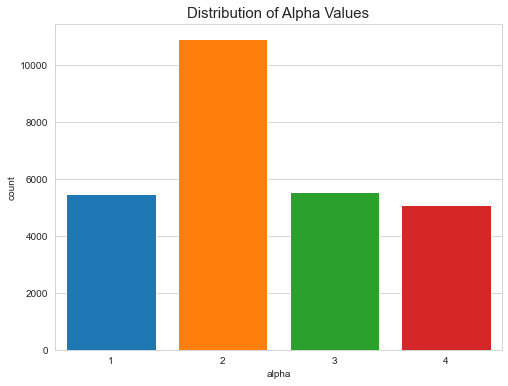

In [42]:
fig,ax=plt.subplots(figsize=(8,6));
sns.countplot(x='alpha',data=train_1,saturation=1);
ax.set_title("Distribution of Alpha Values",size=15);

#### Bivariate analysis

**`SF1-7`** with **`alpha`**

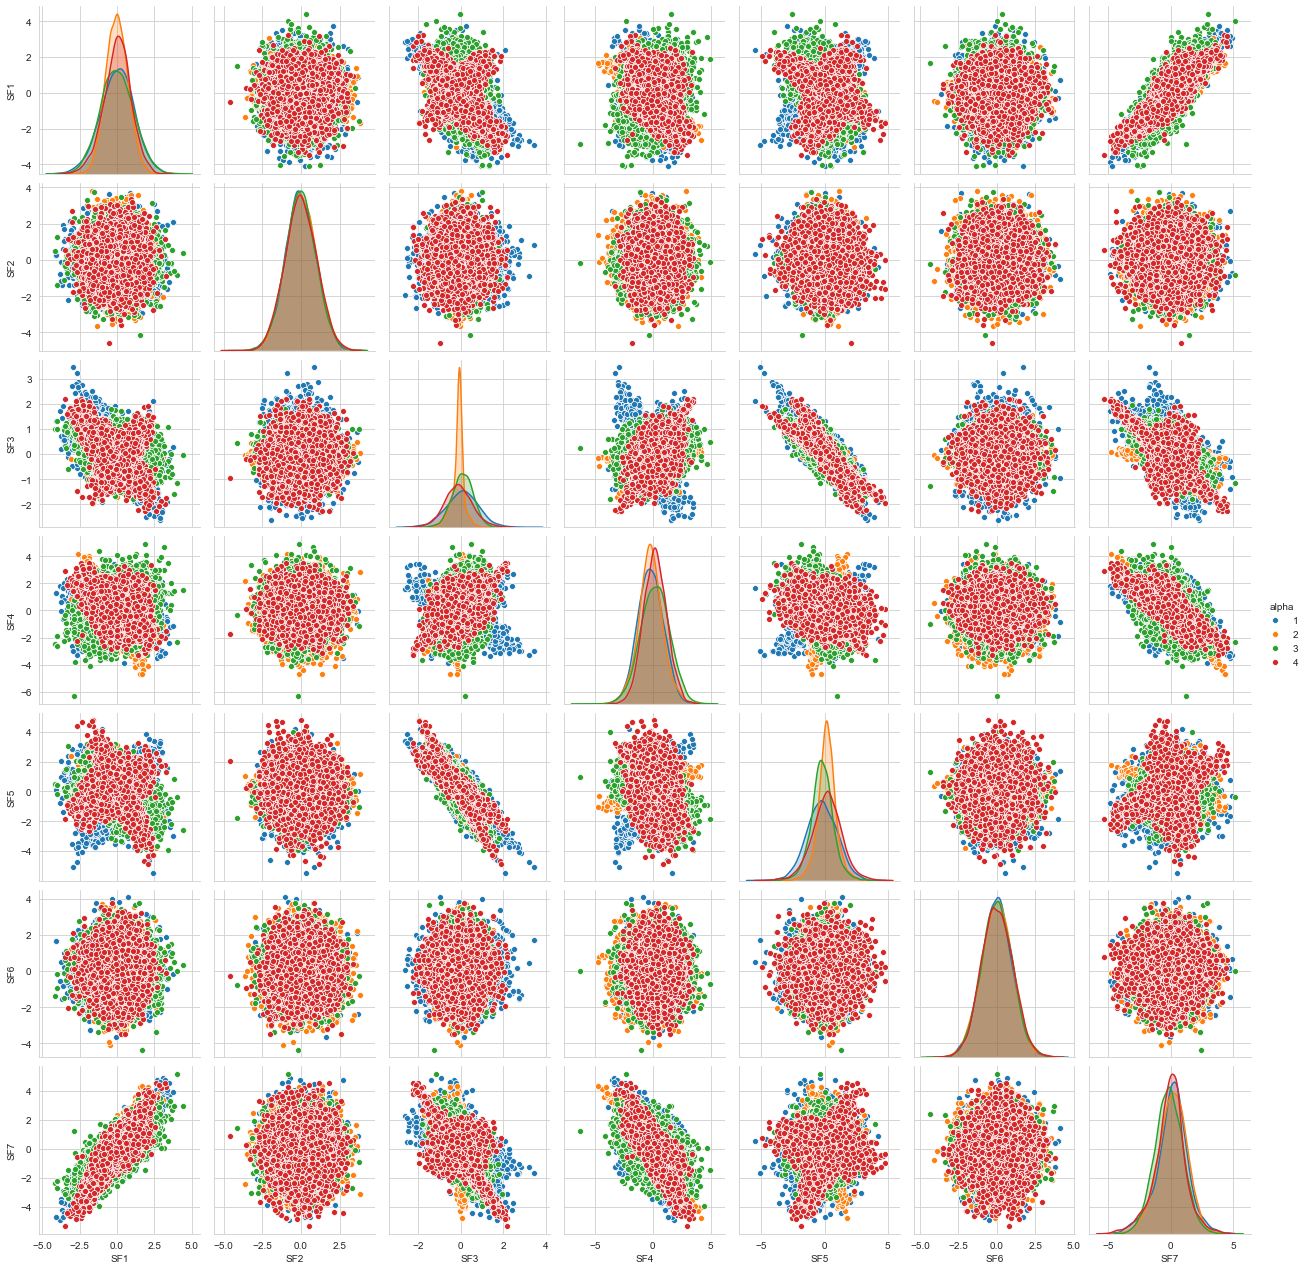

In [43]:
sns.pairplot(train_1,vars=['SF1','SF2','SF3','SF4','SF5','SF6','SF7'],hue='alpha');

### **Tweet dataset**

#### Univariate analysis

**`sentiment`**

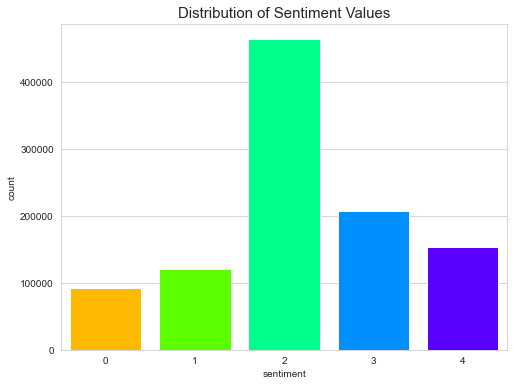

In [44]:
fig,ax=plt.subplots(figsize=(8,6));
sns.countplot(x='sentiment',data=train_2,saturation=1,palette='gist_rainbow');
ax.set_title("Distribution of Sentiment Values",size=15);

#### Bivariate analysis

**`tweet_length`** in tweet as per **`sentiment`**.

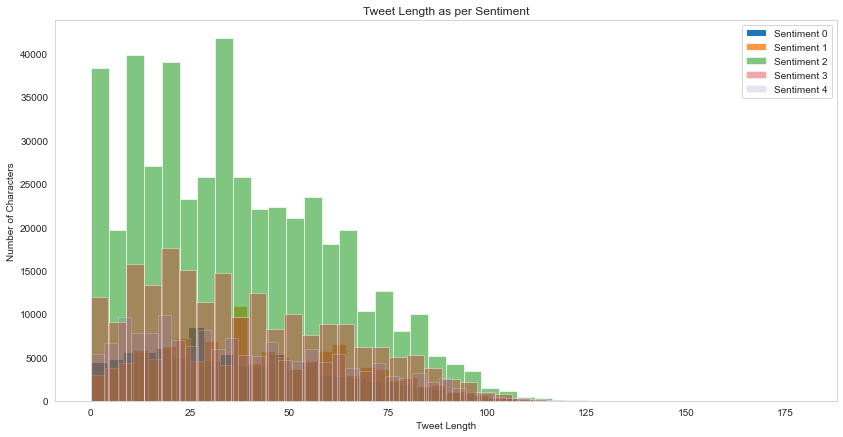

In [45]:
def length(tweet):    
    '''a function which returns the length of text'''
    return len(tweet)

train_2['tweet_length']=train_2['tweet'].apply(length)

plt.rcParams['figure.figsize']=(14,7)
bins=40
plt.hist(train_2[train_2['sentiment']==0]['tweet_length'],alpha=1.0,bins=bins,label='Sentiment 0')
plt.hist(train_2[train_2['sentiment']==1]['tweet_length'],alpha=0.8,bins=bins,label='Sentiment 1')
plt.hist(train_2[train_2['sentiment']==2]['tweet_length'],alpha=0.6,bins=bins,label='Sentiment 2')
plt.hist(train_2[train_2['sentiment']==3]['tweet_length'],alpha=0.4,bins=bins,label='Sentiment 3')
plt.hist(train_2[train_2['sentiment']==4]['tweet_length'],alpha=0.2,bins=bins,label='Sentiment 4')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Characters')
plt.title('Tweet Length as per Sentiment')
plt.legend(loc='upper right')
plt.grid()
plt.show()

- **Wordcloud**:

  It is a visual representation of the **words used in a particular piece of text**, with the **size of each word             indicating its relative frequency**.

  So here we will make different wordclouds, each will be showing most frequent words for specific **sentiment**

**`sentiment 0`**

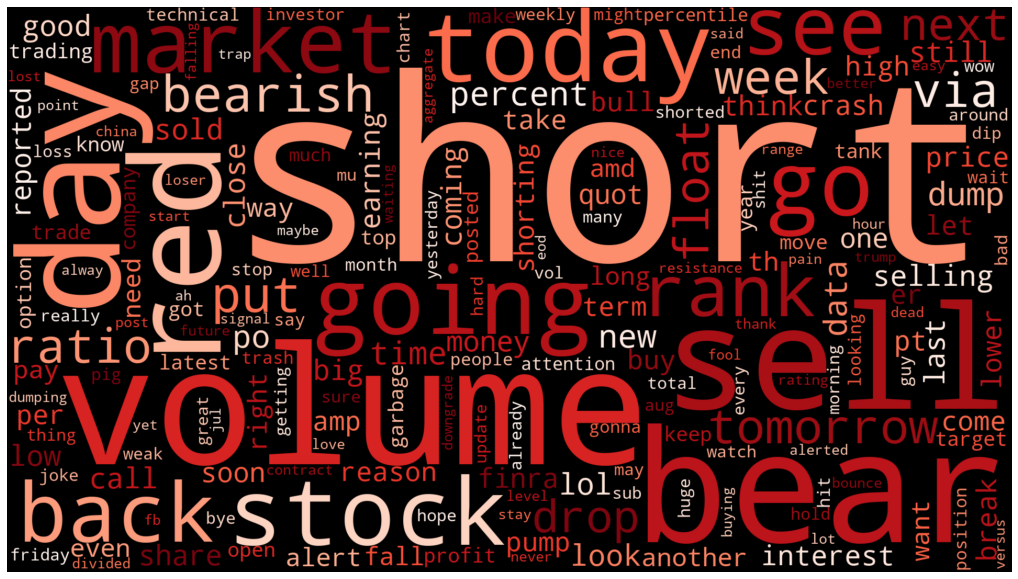

In [46]:
recession=train_2.tweet[train_2.sentiment[train_2.sentiment==0].index]

plt.figure(figsize=(18,32))
wordcloud=WordCloud(min_font_size=2,max_words=200,width=1920,height=1080,collocations=False,colormap='Reds').generate(" ".join(recession))
plt.imshow(wordcloud,interpolation='bilinear');
plt.axis('off');

**`sentiment 1`**

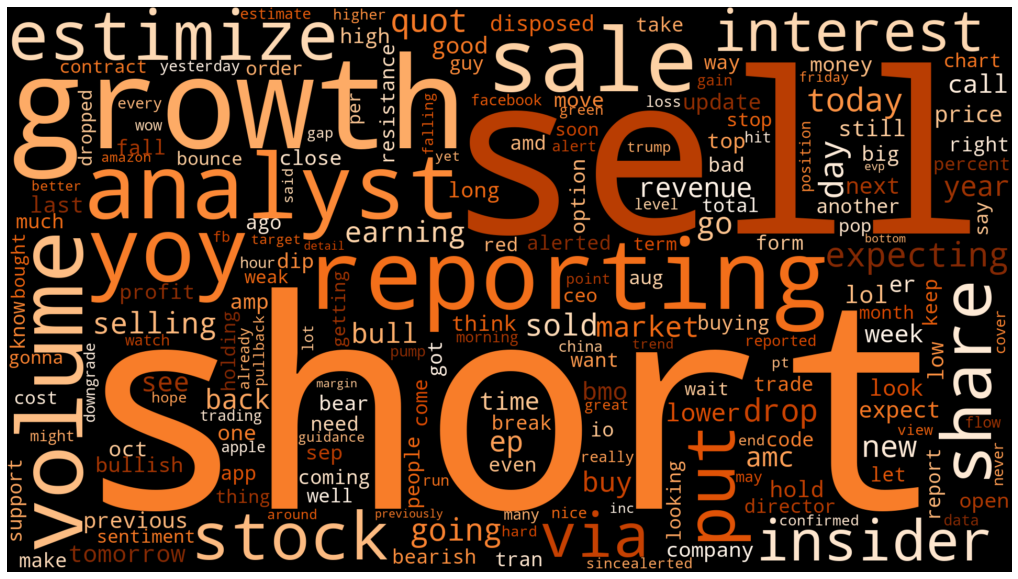

In [47]:
recession=train_2.tweet[train_2.sentiment[train_2.sentiment==1].index]

plt.figure(figsize=(18,32))
wordcloud=WordCloud(min_font_size=2,max_words=200,width=1920,height=1080,collocations=False,colormap='Oranges').generate(" ".join(recession))
plt.imshow(wordcloud,interpolation='bilinear');
plt.axis('off');

**`sentiment 2`**

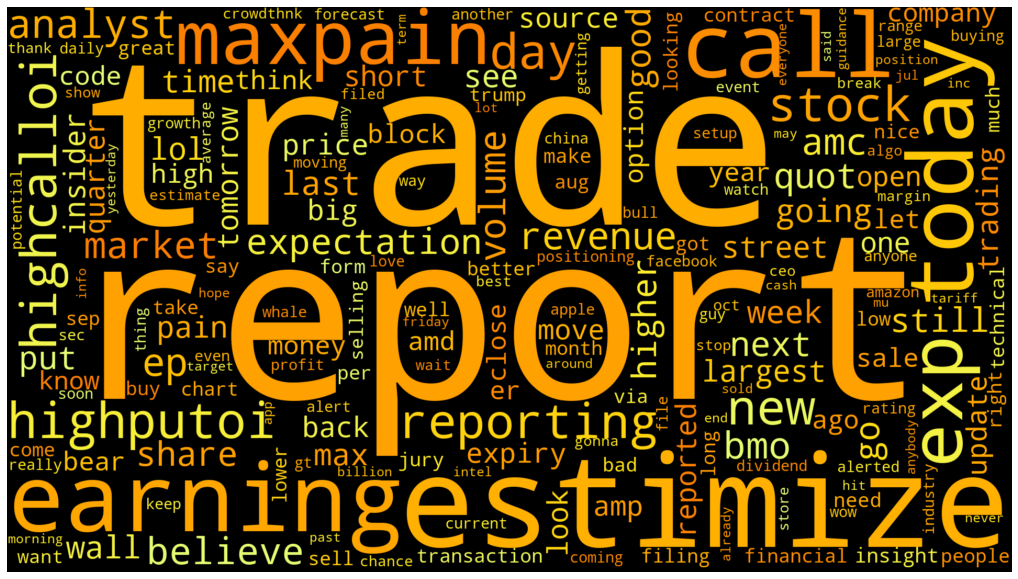

In [48]:
recession=train_2.tweet[train_2.sentiment[train_2.sentiment==2].index]

plt.figure(figsize=(18,32))
wordcloud=WordCloud(min_font_size=2,max_words=200,width=1920,height=1080,collocations=False,colormap='Wistia_r').generate(" ".join(recession))
plt.imshow(wordcloud,interpolation='bilinear');
plt.axis('off');

**`sentiment 3`**

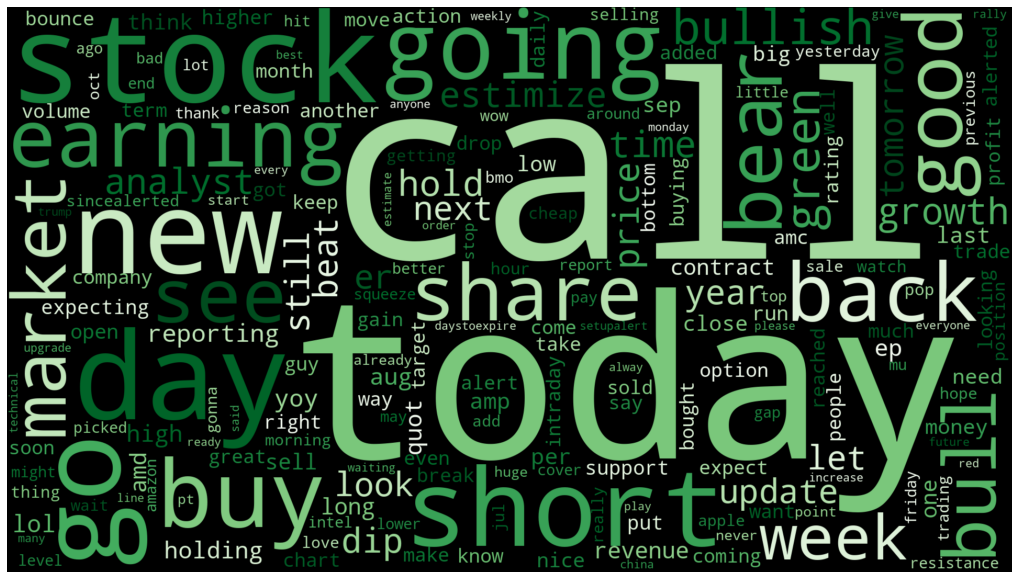

In [49]:
recession=train_2.tweet[train_2.sentiment[train_2.sentiment==3].index]

plt.figure(figsize=(18,32))
wordcloud=WordCloud(min_font_size=2,max_words=200,width=1920,height=1080,collocations=False,colormap='Greens').generate(" ".join(recession))
plt.imshow(wordcloud,interpolation='bilinear');
plt.axis('off');

**`sentiment 4`**

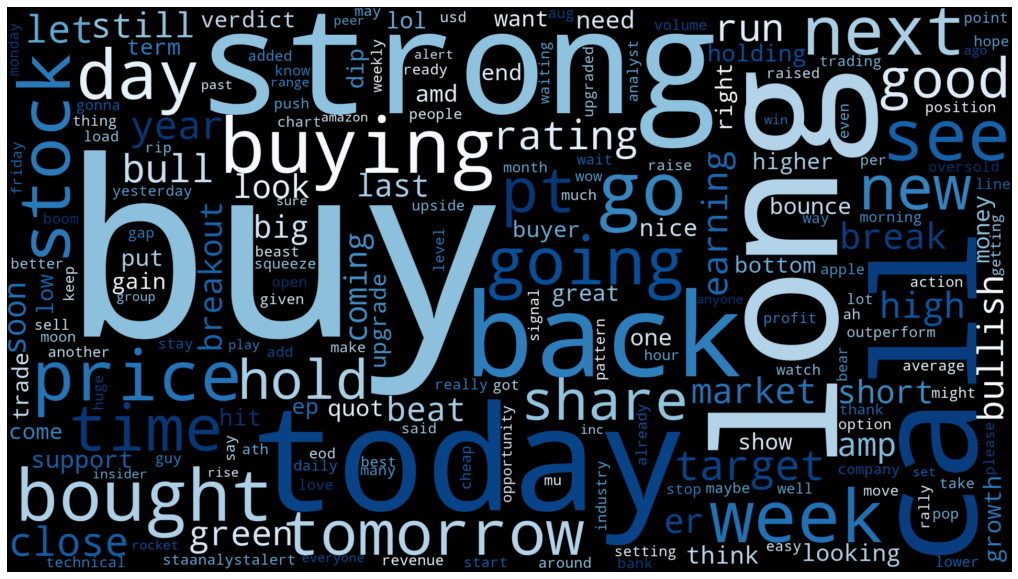

In [50]:
recession=train_2.tweet[train_2.sentiment[train_2.sentiment==4].index]

plt.figure(figsize=(18,32))
wordcloud=WordCloud(min_font_size=2,max_words=200,width=1920,height=1080,collocations=False,colormap='Blues').generate(" ".join(recession))
plt.imshow(wordcloud,interpolation='bilinear');
plt.axis('off');

## Modelling 1
Now we will be doing our machine learning on **tweet** dataset, we will generate **sentiment** for **test_2** and then finally we will merge **factors** and **tweet** datasets and predict **alpha** signal.

### **Tweet dataset**

In [51]:
# splitting our train data into (70%) and validation data into (30%)
X_train,X_val,y_train,y_val=train_test_split(train_2.tweet,train_2.sentiment,test_size=0.30,random_state=44)

- **TF-IDF**:

  In information retrieval, **TFIDF**, short for **term frequency** – **inverse document frequency**, is a numerical         statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [52]:
tv=TfidfVectorizer(max_features=20000) 

#transformed train set
tv_train=tv.fit_transform(X_train)

#transformed validation set
tv_val=tv.transform(X_val)

#transformed test set
tv_test=tv.transform(test_2.tweet)

print('tfidf_train:',tv_train.shape)
print('tfidf_validation:',tv_val.shape)
print('tfidf_test:',tv_test.shape)

tfidf_train: (727391, 20000)
tfidf_validation: (311740, 20000)
tfidf_test: (265022, 20000)


#### Multnomial Naive  Bayes

In [53]:
# defining classifier
mnb=MultinomialNB()

# fitting for tfidf vectorizer.
tfidf_mnb=mnb.fit(tv_train,y_train)

# predicting and printing f1 score for train and validation data
tfidf_train_predict_mnb=tfidf_mnb.predict(tv_train)
tfidf_val_predict_mnb=tfidf_mnb.predict(tv_val)

f1_mnb_tr=f1_score(y_train,tfidf_train_predict_mnb,average='macro')
f1_mnb_val=f1_score(y_val,tfidf_val_predict_mnb,average='macro')
print('Train F1 Score')
print(f1_mnb_tr)
print('Val F1 Score')
print(f1_mnb_val)

Train F1 Score
0.49858700482090246
Val F1 Score
0.4788508005692986


#### Logistic Regression

In [54]:
# defining classifier
lg=LogisticRegression()

# fitting for tfidf vectorizer.
tfidf_lg=lg.fit(tv_train,y_train)

# predicting and printing f1 score for train and validation data
tfidf_train_predict_lg=tfidf_lg.predict(tv_train)
tfidf_val_predict_lg=tfidf_lg.predict(tv_val)

f1_lg_tr=f1_score(y_train,tfidf_train_predict_lg,average='macro')
f1_lg_val=f1_score(y_val,tfidf_val_predict_lg,average='macro')
print('Train F1 Score')
print(f1_lg_tr)
print('Val F1 Score')
print(f1_lg_val)

Train F1 Score
0.5683994307161416
Val F1 Score
0.562732199659582


#### Gradient Boosting

In [55]:
# defining classifier
gb=GradientBoostingClassifier()

# fitting for tfidf vectorizer.
tfidf_gb=gb.fit(tv_train,y_train)

# predicting and printing f1 score for train and validation data
tfidf_train_predict_gb=tfidf_gb.predict(tv_train)
tfidf_val_predict_gb=tfidf_gb.predict(tv_val)

f1_gb_tr=f1_score(y_train,tfidf_train_predict_gb,average='macro')
f1_gb_val=f1_score(y_val,tfidf_val_predict_gb,average='macro')
print('Train F1 Score')
print(f1_gb_tr)
print('Val F1 Score')
print(f1_gb_val)

Train F1 Score
0.4861691596629628
Val F1 Score
0.4850381656623206


**Results**

In [56]:
obs_tweet={'Model':['Multinomial Naive Bayes','Logistic Regression',
                    'Gradient Boosting'],
           'F1 Macro on Training':[f1_mnb_tr,f1_lg_tr,                     
                                   f1_gb_tr], 
           'F1 Macro on Validation':[f1_mnb_val,f1_lg_val,
                                     f1_gb_val]}
results_tweet=pd.DataFrame(obs_tweet)
results_tweet

Model  F1 Macro on Training  F1 Macro on Validation
0  Multinomial Naive Bayes  0.498587              0.478851              
1  Logistic Regression      0.568399              0.562732              
2  Gradient Boosting        0.486169              0.485038

We will use **logistic regresssion** for predicting **sentiment** for **tweet** test set and later we will merge **sentiment** from both **train** and **test** to **factors** **train** and **test** set.

In [57]:
# predicting on tweet test set
#y_pred_lg=lg.predict(tv_test)
#test_2['sentiment']=y_pred_lg
#test_2.to_csv('test_2_sentiment.csv',index=False)

## Merging both **Factors** and **Tweet datastes**

- Reading **test_2_sentiment.csv** file for merging it with **test_1.csv** file.

In [58]:
test_2_sentiment=pd.read_csv('test_2_sentiment.csv')

In [59]:
test_2_sentiment['date']=pd.to_datetime(test_2_sentiment['date'])

- Lower casing tickers from both **factors** and **tweet** datasets.

In [60]:
train_1['ticker']=train_1['ticker'].str.lower()
train_2['ticker']=train_2['ticker'].str.lower()

test_1['ticker']=test_1['ticker'].str.lower()
test_2_sentiment['ticker']=test_2_sentiment['ticker'].str.lower()

In [61]:
# grouping by 'date', 'ticker' and mode of 'sentiment'
train_groupby=train_2.groupby(by=["date","ticker"])['sentiment'].max()
test_groupby=test_2_sentiment.groupby(by=["date","ticker"])['sentiment'].max()

# merging
train=pd.merge(train_1,train_groupby,how='left',left_on=['date','ticker'],right_on=['date','ticker'])
test=pd.merge(test_1,test_groupby,how='left',left_on=['date','ticker'],right_on=['date','ticker'])

## Preprocessing 2

- We will separate **day** and **month** from **date**

In [62]:
train['month']=pd.DatetimeIndex(train['date']).month
test['month']=pd.DatetimeIndex(test['date']).month

train['day']=pd.DatetimeIndex(train['date']).day
test['day']=pd.DatetimeIndex(test['date']).day

train=train.drop(columns=['date'])
test=test.drop(columns=['date'])

## EDA 2

### **Merged dataset**

#### Bivariate analysis

**`day`** and **`month`** with **`SF1`**

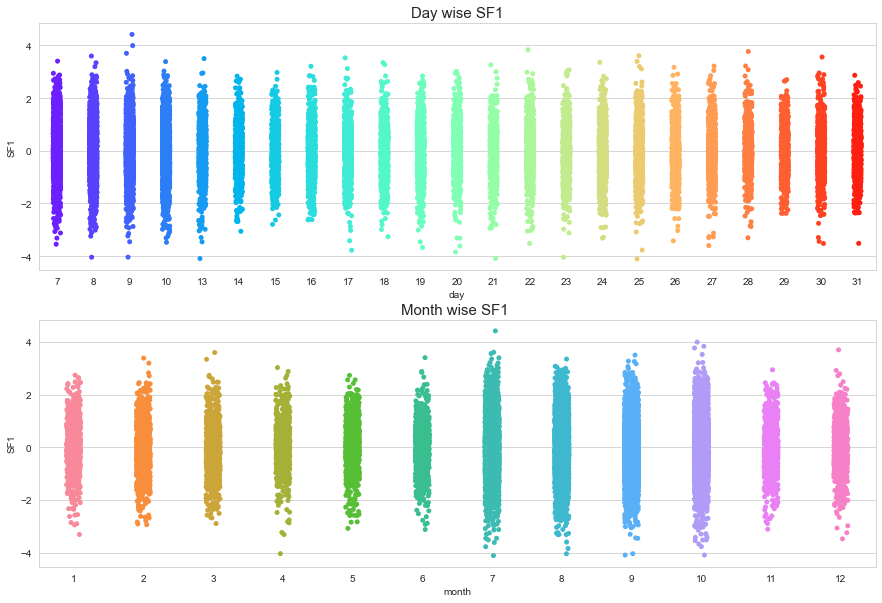

In [63]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.stripplot(x='day',y='SF1',data=train,palette='rainbow',ax=axis1);
axis1.set_title("Day wise SF1",size=15);

g=sns.stripplot(x='month',y='SF1',data=train,ax=axis2);
axis2.set_title("Month wise SF1 ",size=15);

**`day`** and **`month`** with **`SF2`**

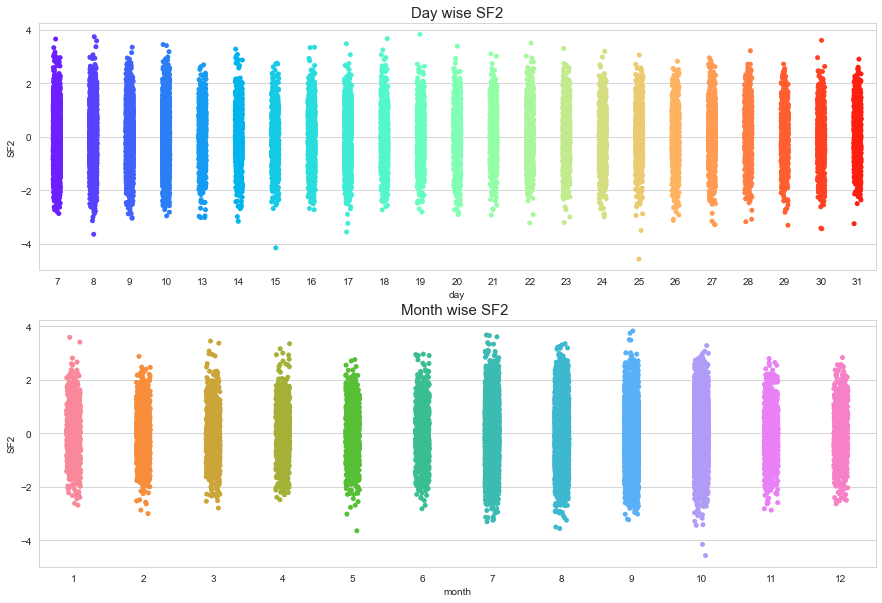

In [64]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.stripplot(x='day',y='SF2',data=train,palette='rainbow',ax=axis1);
axis1.set_title("Day wise SF2",size=15);

g=sns.stripplot(x='month',y='SF2',data=train,ax=axis2);
axis2.set_title("Month wise SF2 ",size=15);

**`day`** and **`month`** with **`SF3`**

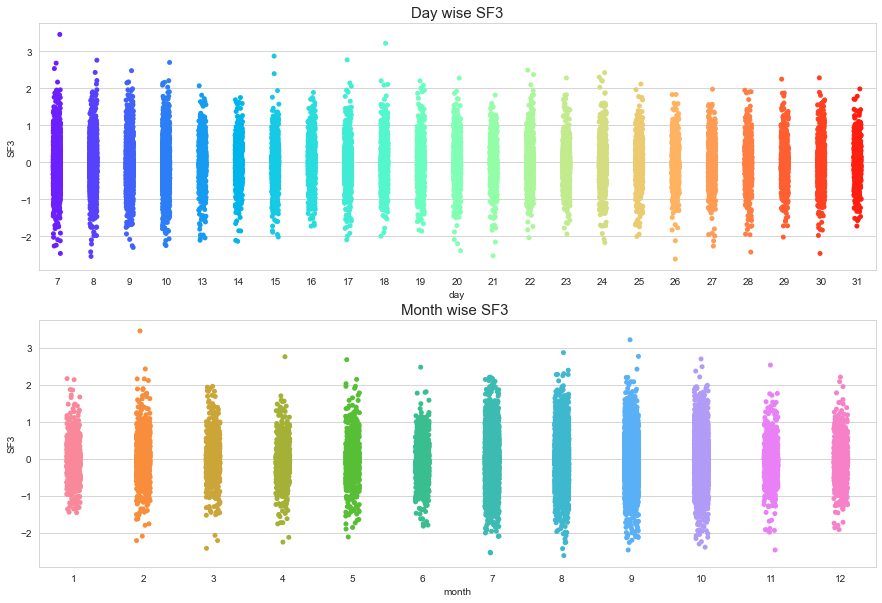

In [65]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.stripplot(x='day',y='SF3',data=train,palette='rainbow',ax=axis1);
axis1.set_title("Day wise SF3",size=15);

g=sns.stripplot(x='month',y='SF3',data=train,ax=axis2);
axis2.set_title("Month wise SF3 ",size=15);

**`day`** and **`month`** with **`SF4`**

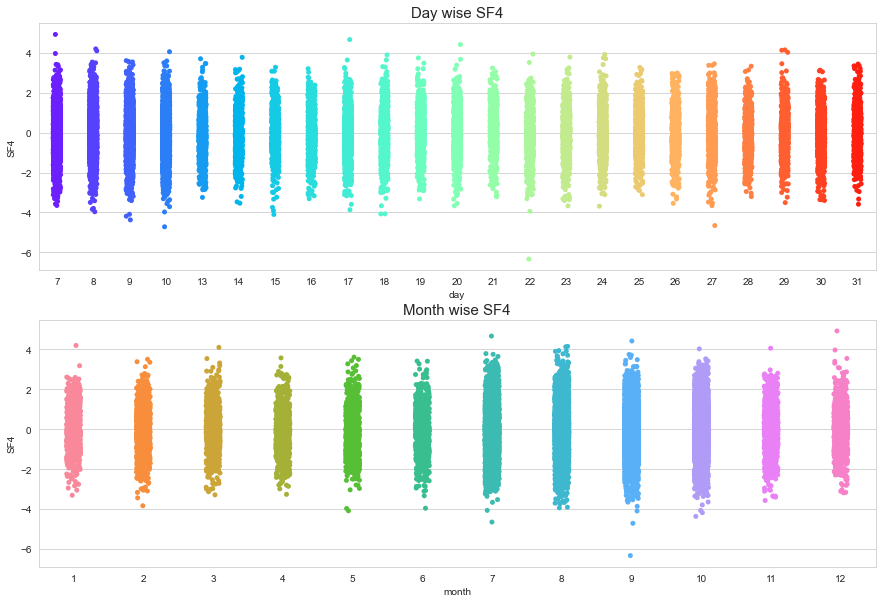

In [66]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.stripplot(x='day',y='SF4',data=train,palette='rainbow',ax=axis1);
axis1.set_title("Day wise SF4",size=15);

g=sns.stripplot(x='month',y='SF4',data=train,ax=axis2);
axis2.set_title("Month wise SF4",size=15);

**`day`** and **`month`** with **`SF5`**

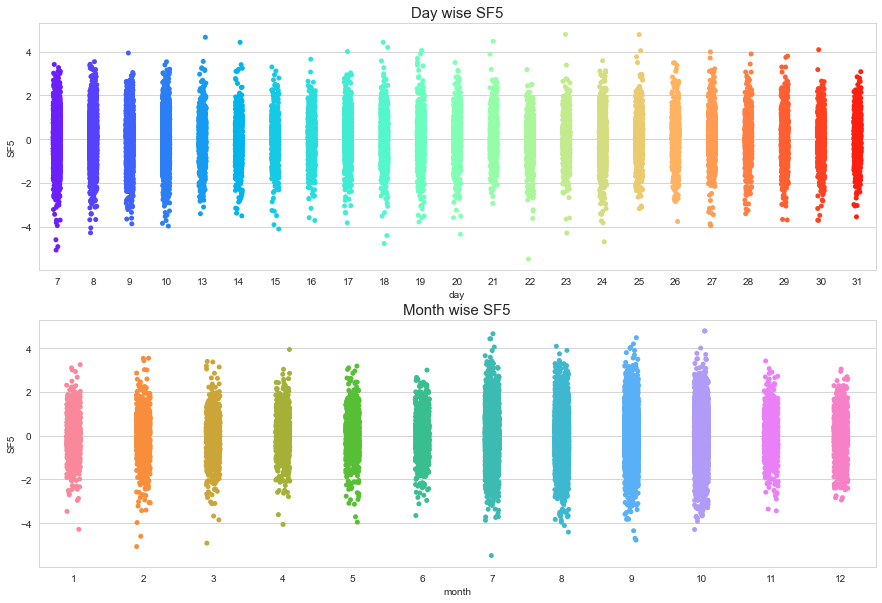

In [67]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.stripplot(x='day',y='SF5',data=train,palette='rainbow',ax=axis1);
axis1.set_title("Day wise SF5",size=15);

g=sns.stripplot(x='month',y='SF5',data=train,ax=axis2);
axis2.set_title("Month wise SF5",size=15);

**`day`** and **`month`** with **`SF6`**

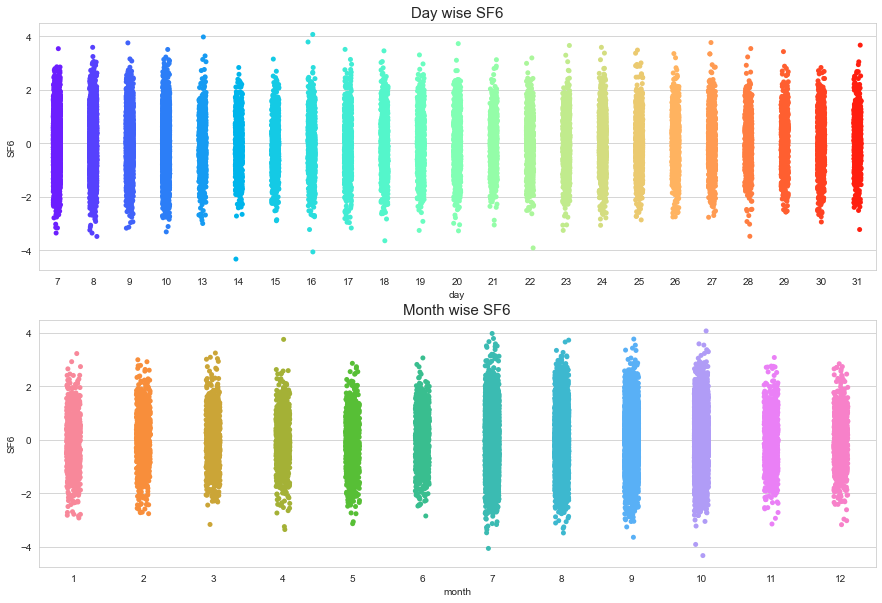

In [68]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.stripplot(x='day',y='SF6',data=train,palette='rainbow',ax=axis1);
axis1.set_title("Day wise SF6",size=15);

g=sns.stripplot(x='month',y='SF6',data=train,ax=axis2);
axis2.set_title("Month wise SF6",size=15);

**`day`** and **`month`** with **`SF7`**

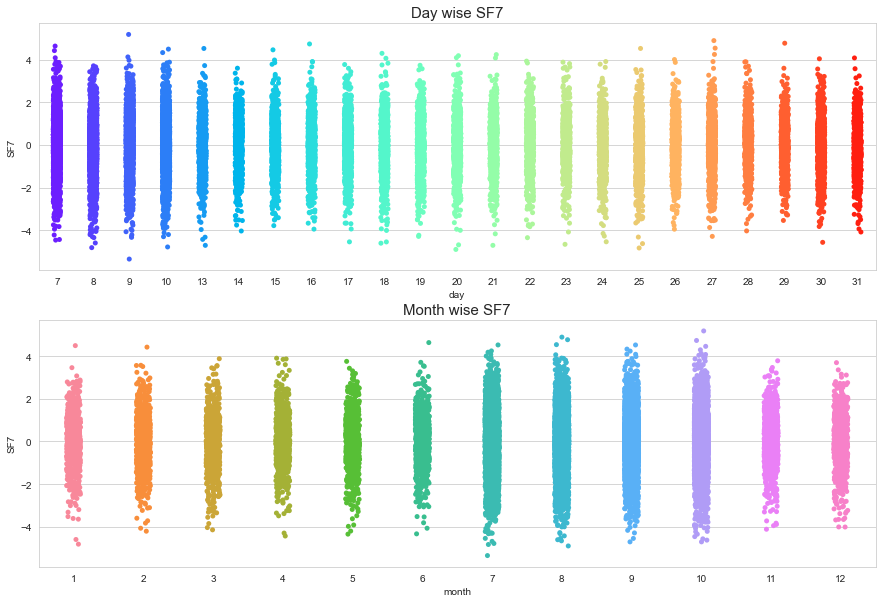

In [69]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.stripplot(x='day',y='SF7',data=train,palette='rainbow',ax=axis1);
axis1.set_title("Day wise SF7",size=15);

g=sns.stripplot(x='month',y='SF7',data=train,ax=axis2);
axis2.set_title("Month wise SF7",size=15);

We can't say anything whether on a specific day or in specific month the value of SF1-7 changes signigicantly.

**`day`** **`month`** with **`sentiment`**

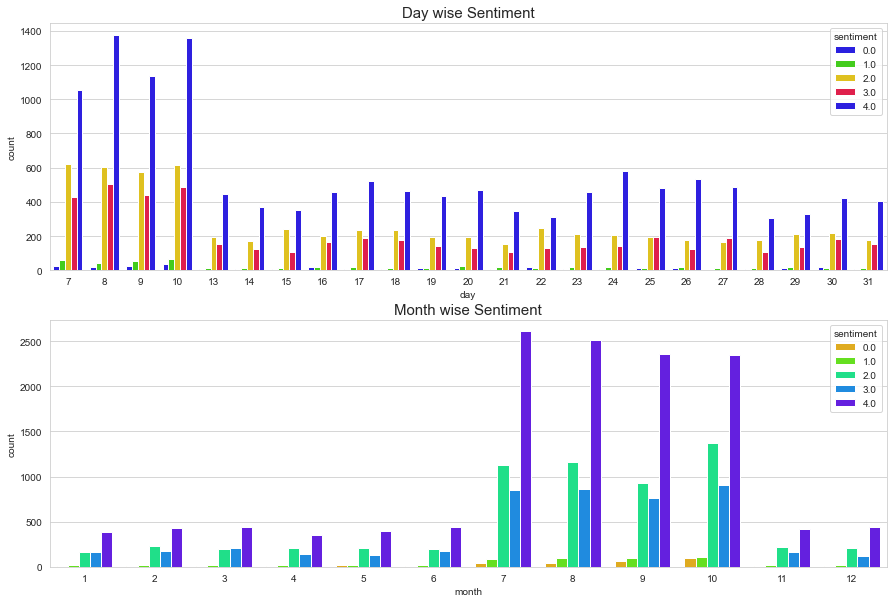

In [70]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.countplot(x='day',hue='sentiment',data=train,palette='prism',ax=axis1);
axis1.set_title("Day wise Sentiment",size=15);

g=sns.countplot(x='month',hue='sentiment',data=train,palette='gist_rainbow',ax=axis2);
axis2.set_title("Month wise Sentiment",size=15);

We can see there is a **increase in (count) almost each sentiment** value on **7th**, **8th**, **9th**, **10th** day and like wise in the month of **July**, **August**, **September** and **October**.

**`day`** and **`month`** with **`alpha`**

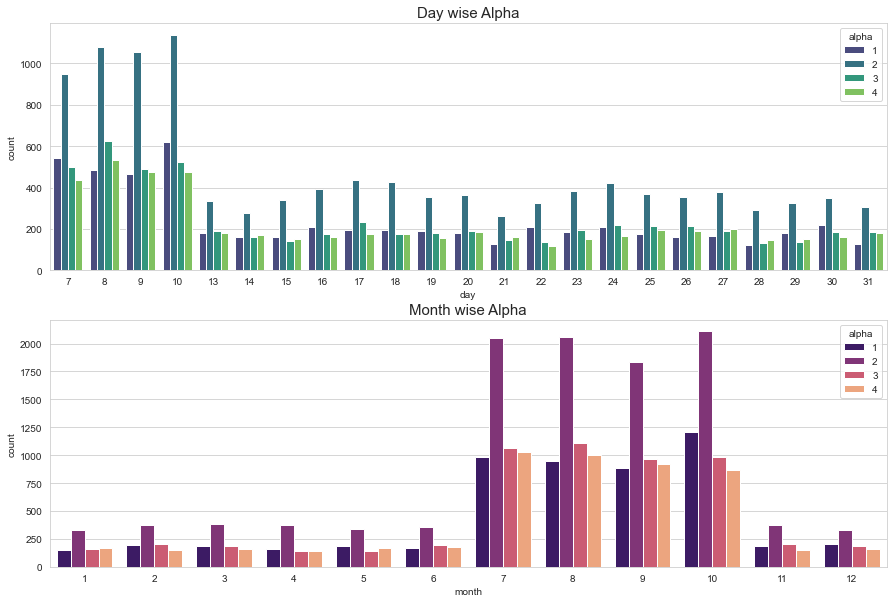

In [71]:
fig,(axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

g=sns.countplot(x='day',hue='alpha',data=train,palette='viridis',ax=axis1);
axis1.set_title("Day wise Alpha",size=15);

g=sns.countplot(x='month',hue='alpha',data=train,palette='magma',ax=axis2);
axis2.set_title("Month wise Alpha",size=15);

Similar pattern can be observed while seeing **day** and **month** with **alpha**, **increase in (count) almost each alpha** value on **7th**, **8th**, **9th**, **10th** day and like wise in the month of **July**, **August**, **September** and **October**.

**`sentiment`** with **`alpha`**

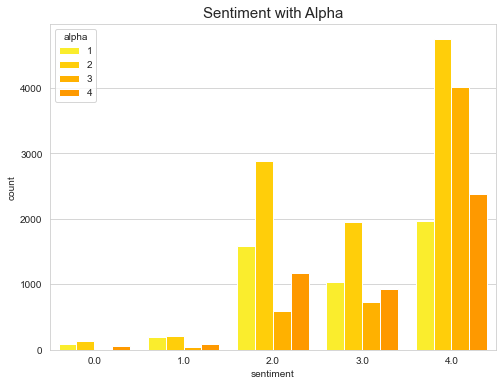

In [72]:
fig,ax=plt.subplots(figsize=(8,6));

g=sns.countplot(x='sentiment',hue='alpha',data=train,palette='Wistia',saturation=1);
ax.set_title("Sentiment with Alpha",size=15);

## Imputations
We will impute **sentiment** column's missing values with **median**

In [73]:
train.isnull().sum()

Id           0   
ticker       0   
SF1          0   
SF2          0   
SF3          0   
SF4          0   
SF5          0   
SF6          0   
SF7          0   
alpha        0   
sentiment    2172
month        0   
day          0   
dtype: int64

In [74]:
train.fillna(train.median(),inplace=True)

## Dummification of categorical variables

In [75]:
dummy_tr_1=pd.get_dummies(train['sentiment'],drop_first=True,prefix='sentiment',prefix_sep='_')
dummy_te_1=pd.get_dummies(test['sentiment'],drop_first=True,prefix='sentiment',prefix_sep='_')

train=pd.concat([train,dummy_tr_1],axis=1)
test=pd.concat([test,dummy_te_1],axis=1)

train=train.drop(columns=['sentiment'])
test=test.drop(columns=['sentiment'])

## Setting dependent and independent variables

In [76]:
X=train.drop(columns=['Id','month','day','ticker','alpha'])
y=train['alpha']

test_for_predictions=test.drop(columns=['Id','month','day','ticker'])

## Splitting our dataset in train and validation set

In [77]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.30,random_state=44)

## Modelling 2

### **Merged dataset**

#### Gradient Boosting

In [78]:
# defining classifier
GB=GradientBoostingClassifier(n_estimators=300,max_depth=2)

# fitting on train set
GB.fit(X_train,y_train)

# predicting and printing f1 score for train and validation data
y_predict_GB_tr=GB.predict(X_train)
y_predict_GB_val=GB.predict(X_val)

f1_GB_tr=f1_score(y_train,y_predict_GB_tr,average='macro')
f1_GB_val=f1_score(y_val,y_predict_GB_val,average='macro')
print('Train F1 Score')
print(f1_GB_tr)
print('Val F1 Score')
print(f1_GB_val)

Train F1 Score
0.6205340821573782
Val F1 Score
0.5855637445353492


#### XGBoost

In [79]:
# defining classifier
XGB=xgb.XGBClassifier()

# fitting on train set
XGB.fit(X_train,y_train)

# predicting and printing f1 score for train and validation data
y_predict_XGB_tr=XGB.predict(X_train)
y_predict_XGB_val=XGB.predict(X_val)

f1_XGB_tr=f1_score(y_train,y_predict_XGB_tr,average='macro')
f1_XGB_val=f1_score(y_val,y_predict_XGB_val,average='macro')
print('Train F1 Score')
print(f1_XGB_tr)
print('Val F1 Score')
print(f1_XGB_val)

Train F1 Score
0.8311924721438549
Val F1 Score
0.6430448325178166


#### Light GBM

In [80]:
# defining classifier
LGBM=LGBMClassifier(max_depth=2,n_estimators=3000)

# fitting on train set
LGBM.fit(X_train,y_train)

# predicting and printing f1 score for train and validation data
y_predict_LGBM_tr=LGBM.predict(X_train)
y_predict_LGBM_val=LGBM.predict(X_val)

f1_LGBM_tr=f1_score(y_train,y_predict_LGBM_tr,average='macro')
f1_LGBM_val=f1_score(y_val,y_predict_LGBM_val,average='macro')
print('Train F1 Score')
print(f1_LGBM_tr)
print('Val F1 Score')
print(f1_LGBM_val)

Train F1 Score
0.7377587969193825
Val F1 Score
0.6192229650952659


#### Cat Boost

In [81]:
# defining classifier
CB=CatBoostClassifier(verbose=False,max_depth=3,n_estimators=3000)

# fitting on train set
CB.fit(X_train,y_train)

# predicting and printing f1 score for train and validation data
y_predict_CB_tr=CB.predict(X_train)
y_predict_CB_val=CB.predict(X_val)

f1_CB_tr=f1_score(y_train,y_predict_CB_tr,average='macro')
f1_CB_val=f1_score(y_val,y_predict_CB_val,average='macro')
print('Train F1 Score')
print(f1_CB_tr)
print('Val F1 Score')
print(f1_CB_val)

Train F1 Score
0.6763024609364217
Val F1 Score
0.6370981614406357


**Results**

In [82]:
obs={'Model':['Gradient Boosting','XGBoost',
              'Light GBM','Cat Boost'],
           'F1 Macro on Training':[f1_GB_tr,f1_XGB_tr,                     
                                   f1_LGBM_tr,f1_CB_tr], 
           'F1 Macro on Validation':[f1_GB_val,f1_XGB_val,                     
                                   f1_LGBM_val,f1_CB_val]}
results=pd.DataFrame(obs)
results

Model  F1 Macro on Training  F1 Macro on Validation
0  Gradient Boosting  0.620534              0.585564              
1  XGBoost            0.831192              0.643045              
2  Light GBM          0.737759              0.619223              
3  Cat Boost          0.676302              0.637098

We will use **Cat Boost** algorithm to predict on our **test** set.